In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
x_train = pd.read_csv('../data/x_train.csv', index_col=0, dtype = {'PatientID' : object})
y_train = pd.read_csv('../data/y_train.csv', index_col=0, dtype = {'PatientID' : object})

## Feature Selection

### Correlation Matrix

<Axes: >

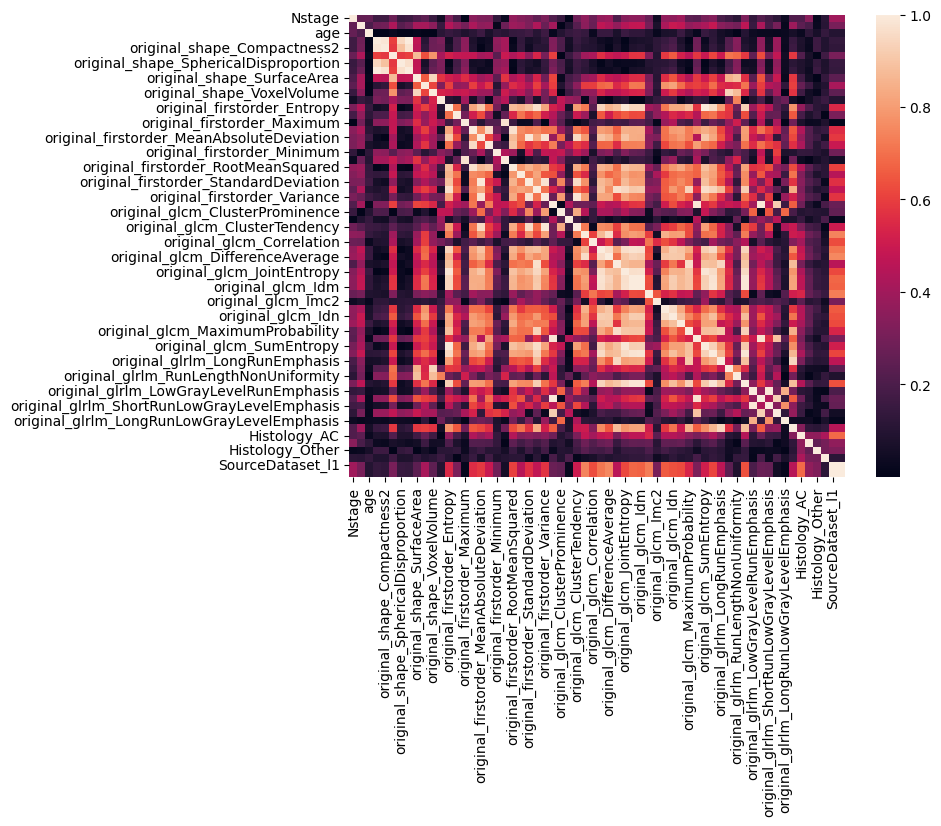

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(x_train.corr().abs(), annot=False)

Certain features are strongly correlated. Let's filter some of them using the VIF criterion. 

### VIF selection

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = x_train.select_dtypes(include='float64')

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif_data[vif_data.VIF < 10].sort_values(by='VIF', ascending=False))

,Variable,VIF
3,original_shape_Maximum3DDiameter,9.283496
11,original_firstorder_Kurtosis,8.816226
0,age,1.267041


We need to reduce the number of features with a VIF of less than 10. Let's start with a PCA.

### PCA

In [7]:
from sklearn.decomposition import PCA

X = x_train.select_dtypes(include='float64')
n, p = X.shape
pca = PCA()
scaled_acp = pca.fit_transform(X)
corvar=pca.get_covariance()

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

explained_variance_df = pd.DataFrame({
    'Composant': [f'Dim{i+1}' for i in range(len(explained_variance))],
    'Variance expliquée': explained_variance,
    'Variance cumulée': cumulative_variance
})

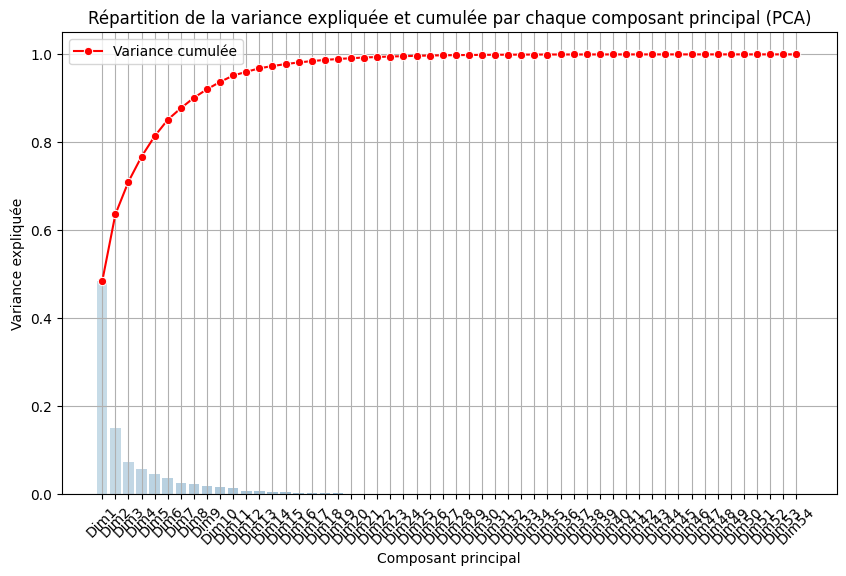

In [9]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Composant', y='Variance expliquée', data=explained_variance_df, palette='Blues_d', alpha=0.7)
sns.lineplot(x='Composant', y='Variance cumulée', data=explained_variance_df, color='red', marker='o', label='Variance cumulée')

plt.xlabel('Composant principal')
plt.ylabel('Variance expliquée')
plt.title('Répartition de la variance expliquée et cumulée par chaque composant principal (PCA)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We have retained only the first 5 dimensions because they explain more than 80% of the variance.

In [ ]:
pca_df = pd.DataFrame({
    "PatientID" : X.index,
    "Dim1" : scaled_acp[:,0],
    "Dim2" : scaled_acp[:,1],
    "Dim3" : scaled_acp[:,2],
    "Dim4" : scaled_acp[:,3],
    "Dim5" : scaled_acp[:,4],
})

pca_df.set_index("PatientID", inplace=True)
pca_df.head()

,Dim1,Dim2,Dim3,Dim4,Dim5
PatientID,,,,,
202,-4.757162,-1.167978,-0.211508,-1.287309,-0.205473
371,0.327184,-0.787342,0.079065,-0.989524,1.149569
246,3.497061,2.807429,0.456031,0.485746,0.858497
240,-0.365618,1.606162,-0.364705,-0.575138,1.418095
284,1.493510,-1.102749,-0.365798,-1.516970,-1.222656


In [11]:
x_train = pd.merge(x_train.select_dtypes({'int64'}), pca_df, how='inner', left_index= True, right_index=True, sort = True)

### VIF selection 2

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = x_train

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

columns_toDrop = vif_data[vif_data.VIF > 10].Variable.to_list()
display(vif_data[vif_data.VIF > 10].sort_values(by='VIF', ascending=False))

,Variable,VIF
2,Histology_AC,inf
3,Histology_LG,inf
4,Histology_Other,inf
5,Histology_SCC,inf
6,SourceDataset_l1,inf
7,SourceDataset_l2,inf


In [14]:
columns_toDrop

['Histology_AC',
 'Histology_LG',
 'Histology_Other',
 'Histology_SCC',
 'SourceDataset_l1',
 'SourceDataset_l2']

In [15]:
x_train = x_train.drop(columns= columns_toDrop)

In [16]:
train = pd.merge(y_train, x_train, how ='inner', left_index=True, right_index=True, sort=True)
train.head()

,SurvivalTime,Event,Nstage,Tstage,Dim1,Dim2,Dim3,Dim4,Dim5
PatientID,,,,,,,,,
002,638,0,0,3,7.346370,-0.192415,-0.185075,1.192654,0.126371
003,421,0,3,1,-4.920469,-1.965836,-1.752034,3.146114,2.300233
004,465,1,0,3,2.047051,-2.693129,0.730803,-1.845038,2.230047
005,1295,1,0,2,8.476566,4.133959,0.101228,1.427226,-3.391035
007,1393,0,0,4,6.451561,-0.817483,1.163006,0.073134,0.899141


### Forward selection

In [17]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()

In [29]:
def forward_selection_pvalue(X, verbose, threshold = 0.05):
    included = ['SurvivalTime','Event']
    features = X.columns.to_list()
    cph = CoxPHFitter()
    while True :
        remaining_features = list(set(features) - set(included))
        p_val = pd.Series(index=remaining_features)

        for feature in remaining_features :
            x_train_selection = X[included + [feature]]
            model = cph.fit(x_train_selection, duration_col='SurvivalTime', event_col='Event')
            p_value = model.summary.loc[feature, 'p']
            p_val[feature] = p_value

        min_pval = p_val.min()

        if min_pval < threshold :
            feature_selec = p_val.idxmin()
            included.append(feature_selec)
            if verbose :
                print(f'On ajoute la feature {feature_selec} avec une p_val de {min_pval}')
        else :
            feature_selec = p_val.idxmin()
            if verbose :
                print(f'On n\'ajoute pas la feature {feature_selec} avec une p_val de {min_pval}')
            break
    return included

def backward_selection_pvalue(X, verbose, threshold = 0.05):
    included = X.columns.to_list()
    cph = CoxPHFitter()
    while True :
        x_train_selection = X[included]
        model = cph.fit(x_train_selection, duration_col='SurvivalTime', event_col='Event') #regression des moindres carrés
        p_val = pd.Series(index=included)
        remaining_f = list(set(included) - set(['SurvivalTime','Event']))
        for feature in remaining_f :
            p_value = model.summary.loc[feature , 'p']
            p_val[feature] = p_value
        max_pval = p_val.max()

        if max_pval > threshold :
            feature_selec = p_val.idxmax()
            included.remove(feature_selec)
            if verbose :
                print(f'On élimine la feature {feature_selec} avec une p_val de {max_pval}')
        else:
            if verbose :
                print('Aucune feature à éliminer, le processus est terminé.')
            break  # Sortir de la boucle si toutes les p-values sont inférieures au seuil
    return included

In [31]:
forward_selection_pvalue(train, True, 0.05)

On ajoute la feature Dim1 avec une p_val de 8.108270247784148e-11
On ajoute la feature Dim3 avec une p_val de 0.00045717543473993756
On ajoute la feature Nstage avec une p_val de 0.00877176572845096
On ajoute la feature Dim4 avec une p_val de 0.03705609039261439
On n'ajoute pas la feature Dim2 avec une p_val de 0.17077264491942168


['SurvivalTime', 'Event', 'Dim1', 'Dim3', 'Nstage', 'Dim4']

In [32]:
backward_selection_pvalue(train, True, 0.05)

On élimine la feature Tstage avec une p_val de 0.748520930905955
On élimine la feature Dim5 avec une p_val de 0.45694662782655815
On élimine la feature Dim2 avec une p_val de 0.17077264491942207
Aucune feature à éliminer, le processus est terminé.


['SurvivalTime', 'Event', 'Nstage', 'Dim1', 'Dim3', 'Dim4']

Both backward and foreward feeature selection sugest to conserve only those feeatures : ['SurvivalTime', 'Event', 'Nstage', 'Dim1', 'Dim3', 'Dim4']

In [34]:
train = train[['SurvivalTime', 'Event', 'Nstage', 'Dim1', 'Dim3', 'Dim4']]
train.head()

,SurvivalTime,Event,Nstage,Dim1,Dim3,Dim4
PatientID,,,,,,
202,1378,0,0,-4.757162,-0.211508,-1.287309
371,379,1,2,0.327184,0.079065,-0.989524
246,573,1,3,3.497061,0.456031,0.485746
240,959,0,2,-0.365618,-0.364705,-0.575138
284,2119,0,3,1.493510,-0.365798,-1.516970


<Axes: >

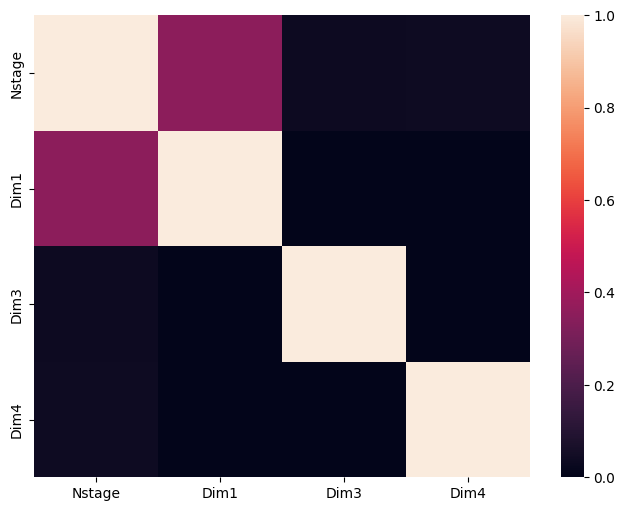

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(train[['Nstage', 'Dim1', 'Dim3', 'Dim4']].corr().abs(), annot=False)

## Cox’s proportional hazard model

<Axes: xlabel='timeline'>

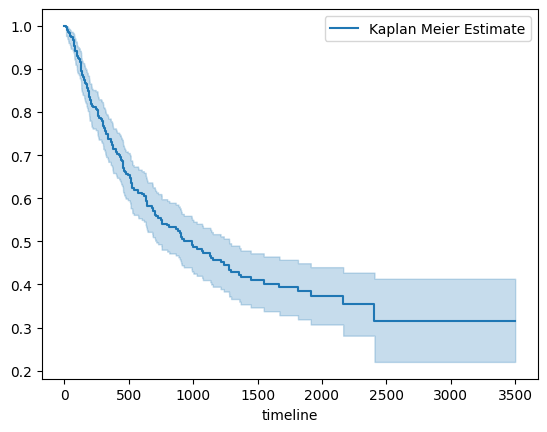

In [48]:
from lifelines import KaplanMeierFitter


km = KaplanMeierFitter() 
km.fit(train.SurvivalTime, train.Event, label='Kaplan Meier Estimate')

## Create an estimate
km.plot(ci_show=True)

In [ ]:
from lifelines.utils import median_survival_times
median_ = km.median_survival_time_
median_confidence_interval_ = median_survival_times(km.confidence_interval_)
print(median_)
print(median_confidence_interval_)

988.0
     Kaplan Meier Estimate_lower_0.95  Kaplan Meier Estimate_upper_0.95
0.5                             714.0                            1280.0


Text(0.5, 1.0, 'Survival of different gender group')

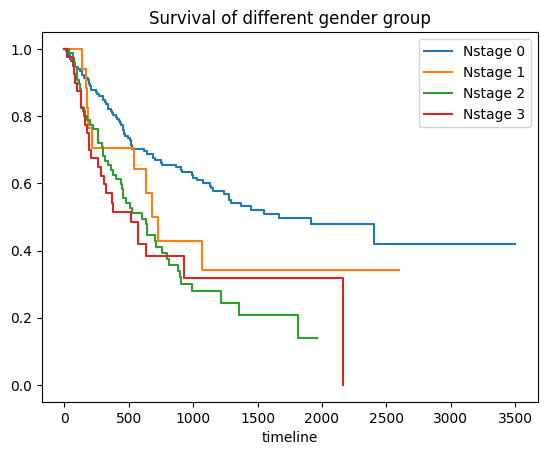

In [55]:
ax = plt.subplot(111)
n0 = (x_train.Nstage== 0)
n1 = (x_train.Nstage== 1)
n2 = (x_train.Nstage== 2)
n3 = (x_train.Nstage== 3)


km.fit(durations = train.SurvivalTime[n0], event_observed = train.Event[n0], label = "Nstage 0")
km.plot_survival_function(ax = ax, ci_show=False)
km.fit(durations = train.SurvivalTime[n1], event_observed = train.Event[n1], label = "Nstage 1")
km.plot_survival_function(ax = ax, ci_show=False)
km.fit(durations = train.SurvivalTime[n2], event_observed = train.Event[n2], label = "Nstage 2")
km.plot_survival_function(ax = ax, ci_show=False)
km.fit(durations = train.SurvivalTime[n3], event_observed = train.Event[n3], label = "Nstage 3")
km.plot_survival_function(ax = ax, ci_show=False)
plt.title("Survival of different gender group")

In [ ]:
cph = CoxPHFitter()

cph.fit(train, duration_col='SurvivalTime', event_col='Event')



<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 162
   partial log-likelihood = -807.34
         time fit was run = 2024-11-15 15:33:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Nstage     0.19      1.21      0.07            0.05            0.33                1.05                1.39
Dim1       0.09      1.10      0.02            0.06            0.13                1.06                1.14
Dim3       0.13      1.14      0.04            0.05            0.21                1.05                1.24
Dim4      -0.10      0.91      0.05           -0.19           -0.01                0.83                0.99

           cmp to     z      p  -log2(p)
covariate                               
Nstage       0.00  2.69   0.01      7.12
Dim1         0.00  5.34 <0.005     23.36
Dim3         0.00  3.19 <0.005      9.48
Dim4         0.00 -2.09   0.04      4.75
---
Concordance = 0.69
Partial AIC = 1622.68
log-likelihood ratio test = 63.20 on 4 df
-log2(p) of ll-ratio test = 40.56

<Axes: xlabel='log(HR) (95% CI)'>

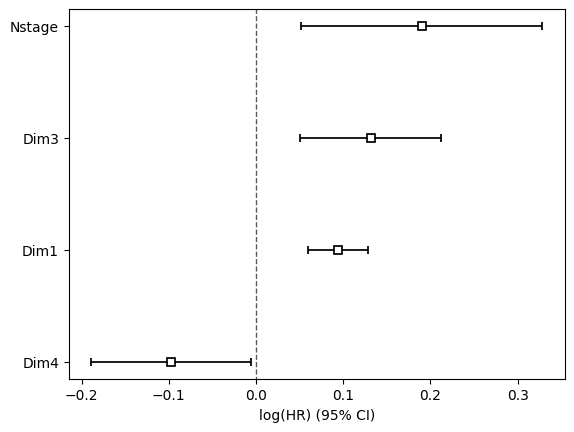

In [41]:
cph.plot()

In [47]:
x_test = pd.read_csv('../data/x_test.csv', index_col=0)

X = x_test.select_dtypes(include='float64')

scaled_acp = pca.fit_transform(X)
corvar=pca.get_covariance()

pca_test = pd.DataFrame({
    "PatientID" : X.index,
    "Dim1" : scaled_acp[:,0],
    "Dim2" : scaled_acp[:,1],
    "Dim3" : scaled_acp[:,2],
    "Dim4" : scaled_acp[:,3],
    "Dim5" : scaled_acp[:,4],
})

pca_test.set_index("PatientID", inplace=True)

x_test = pd.merge(x_test.select_dtypes({'int64'}), pca_test, how='inner', left_index= True, right_index=True, sort = True)
x_test = x_test[['Nstage', 'Dim1', 'Dim3', 'Dim4']]
x_test.head()

,Nstage,Dim1,Dim3,Dim4
PatientID,,,,
0,0,-5.917843,-1.063062,0.742902
1,2,2.526814,0.777315,1.524625
6,2,0.750254,0.298592,1.970885
9,0,-8.099393,-4.720154,-3.930928
10,2,4.484800,0.727717,0.061431


In [58]:
x_test.shape

(125, 4)

In [63]:
cph.predict_survival_function(x_test)

,0,1,6,9,10,12,13,19,27,28,...,404,405,407,408,410,411,412,413,415,419
14.0,0.998958,0.996023,0.996974,0.999172,0.994525,0.998405,0.997043,0.997444,0.995636,0.998898,...,0.994802,0.997780,0.996039,0.997258,0.998605,0.997545,0.999434,0.998331,0.995970,0.997369
20.0,0.998958,0.996023,0.996974,0.999172,0.994525,0.998405,0.997043,0.997444,0.995636,0.998898,...,0.994802,0.997780,0.996039,0.997258,0.998605,0.997545,0.999434,0.998331,0.995970,0.997369
21.0,0.998958,0.996023,0.996974,0.999172,0.994525,0.998405,0.997043,0.997444,0.995636,0.998898,...,0.994802,0.997780,0.996039,0.997258,0.998605,0.997545,0.999434,0.998331,0.995970,0.997369
24.0,0.997912,0.992047,0.993945,0.998342,0.989061,0.996807,0.994085,0.994886,0.991275,0.997793,...,0.989611,0.995557,0.992079,0.994513,0.997208,0.995087,0.998865,0.996658,0.991941,0.994735
25.0,0.996863,0.988067,0.990911,0.997508,0.983597,0.995203,0.991120,0.992320,0.986911,0.996684,...,0.984421,0.993327,0.988114,0.991762,0.995804,0.992622,0.998294,0.994979,0.987908,0.992095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078.0,0.590572,0.133695,0.216431,0.658234,0.062531,0.446672,0.224221,0.274676,0.109880,0.573059,...,0.071949,0.325576,0.134775,0.249929,0.494244,0.289039,0.751176,0.430146,0.130144,0.264410
3222.0,0.590572,0.133695,0.216431,0.658234,0.062531,0.446672,0.224221,0.274676,0.109880,0.573059,...,0.071949,0.325576,0.134775,0.249929,0.494244,0.289039,0.751176,0.430146,0.130144,0.264410
3251.0,0.590572,0.133695,0.216431,0.658234,0.062531,0.446672,0.224221,0.274676,0.109880,0.573059,...,0.071949,0.325576,0.134775,0.249929,0.494244,0.289039,0.751176,0.430146,0.130144,0.264410
3259.0,0.590572,0.133695,0.216431,0.658234,0.062531,0.446672,0.224221,0.274676,0.109880,0.573059,...,0.071949,0.325576,0.134775,0.249929,0.494244,0.289039,0.751176,0.430146,0.130144,0.264410


<Axes: >

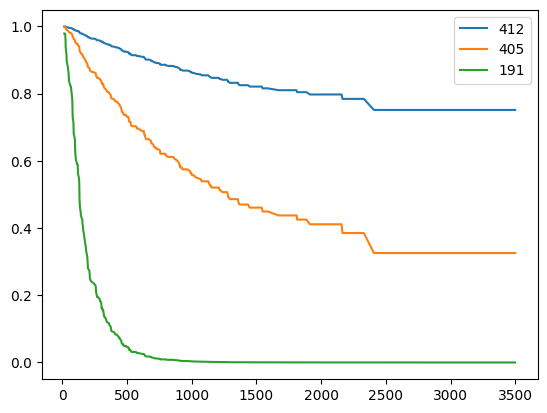

In [82]:

cph.predict_survival_function(x_test.loc[[412, 405, 191]]).plot()

In [83]:
cph.predict_median(x_test)

0         inf
1       635.0
6       886.0
9         inf
10      456.0
        ...  
411    1134.0
412       inf
413    2165.0
415     632.0
419    1002.0
Name: 0.5, Length: 125, dtype: float64

In [62]:
cph.predict_partial_hazard(x_test)

0      0.385928
1      1.474496
6      1.121507
9      0.306444
10     2.031327
         ...   
411    0.909520
412    0.209659
413    0.618196
415    1.494223
419    0.974784
Length: 125, dtype: float64